In [2]:
%matplotlib inline

In [102]:
import networkx as nx
import numpy as np
import pickle as pkl
import pandas as pd

from graph_tool import load_graph
from graph_tool.draw import graph_draw
from graph_tool.topology import kcore_decomposition
from networkx.drawing.nx_agraph import graphviz_layout
from networkit import Glist
from tqdm import tqdm

from fixtures import house_graph
from graph_helpers import sort_pair
# from networkit import overview
from graph_helpers import gt2nk

In [4]:
def get_kcore(g):
    return kcore_decomposition(g).a

In [5]:
original_g = house_graph()
# gnk = gt2nk(g)

In [16]:
"""
the graph:

       0
      / \
     /   \
    /     \
    1 --- 2
    |    /|
    |   / |
    | /   |
    |/    |
    3 --- 4 --- 5
"""   

'\nthe graph:\n\n       0\n      /      /       /         1 --- 2\n    |    /|\n    |   / |\n    | /   |\n    |/    |\n    3 --- 4 --- 5\n'

In [66]:
def get_edge_dag(original_g, cand_edges, verbose=True):
    g = original_g.copy()
    # old_core = get_kcore(g)
    pending_edges_g = nx.Graph()
    active_edges_g = nx.Graph()

    edge2meta_node = {}

    pending_edges = set()
    active_edges = set()

    edge_dag = nx.DiGraph()
    # meta_nodes = []
    # meta_edges = []

    for u, v in tqdm(cand_edges):
        u, v = sort_pair([u, v])

        old_core = get_kcore(g)
        g.add_edge(u, v)
        new_core = get_kcore(g)
        core_increase = int((new_core - old_core).sum())

        affected_nodes = list((new_core != old_core).nonzero()[0])

        if affected_nodes:   
            if verbose:
                print('adding ({}, {}) promotes {}'.format(u, v, affected_nodes))

            # get related pending edges
            # and create the meta node
            related_pending_edges = []
            for i in affected_nodes:
                if pending_edges_g.has_node(i):
                    for j in pending_edges_g[i]:
                        if new_core[i] >= new_core[j]:
                            related_pending_edges.append((i, j))        

            related_pending_edges.append((u, v))
            # print('related pending edges', related_pending_edges)
            meta_node = tuple(set(sorted(map(sort_pair, related_pending_edges))))
            
            if verbose:
                print('new meta node:', meta_node)

            # create the indexing
            for e in meta_node:
                edge2meta_node[e] = meta_node

            # get meta nodes dependencies            
            related_active_edges = []
            for i in affected_nodes:
                if active_edges_g.has_node(i):
                    for j in active_edges_g[i]:
                        if new_core[i] <= new_core[j]:  # only peer or higher-core neighbors
                            related_active_edges.append((i, j))        

            related_active_edges = set(map(sort_pair, related_active_edges))
            # print('related active edges', related_active_edges)

            parent_meta_nodes = set()
            for e in related_active_edges:
                parent_meta_nodes.add(edge2meta_node[e])
            if verbose:
                print('parent meta nodes', parent_meta_nodes)

            # update the edge_dag
            attrs = {'local_gain': core_increase,
                     'local_weighted_gain': core_increase / len(meta_node)}
            edge_dag.add_node(
                meta_node, 
                attrs)
            inc_edge_cost = len(meta_node)
            inc_gain = core_increase
            for n in parent_meta_nodes:
                edge_dag.add_edge(n, meta_node)
                inc_edge_cost += edge_dag.node[n]['inc_edge_cost']
                inc_gain += edge_dag.node[n]['inc_gain']
                inc_gain
            edge_dag.node[meta_node]['inc_edge_cost'] = inc_edge_cost
            edge_dag.node[meta_node]['inc_gain'] = inc_gain
            edge_dag.node[meta_node]['inc_weighted_gain'] = inc_gain / inc_edge_cost

            # these edges are not pending any more
            pending_edges_g.remove_edges_from(related_pending_edges)
            # these edges become active
            active_edges_g.add_edges_from(related_pending_edges)        
        else:
            if verbose:
                print('adding ({}, {}) promotes nothing'.format(u, v))
            pending_edges_g.add_edge(u, v)
        if verbose:
            print('-' * 10)
    return edge_dag

In [110]:
cand_edges = [(2, 5), (0, 5), (0, 4), (1, 4), (0, 3)]
toy_edge_dag = get_edge_dag(original_g, cand_edges,
                            verbose=False)

100%|██████████| 5/5 [00:00<00:00, 316.10it/s]


In [111]:
for n in toy_edge_dag.nodes():
    print(n, toy_edge_dag.node[n])

((2, 5),) {'inc_edge_cost': 1, 'inc_weighted_gain': 1.0, 'inc_gain': 1, 'local_gain': 1, 'local_weighted_gain': 1.0}
((0, 3), (1, 4), (0, 4)) {'inc_edge_cost': 3, 'inc_weighted_gain': 1.6666666666666667, 'inc_gain': 5, 'local_gain': 5, 'local_weighted_gain': 1.6666666666666667}
((0, 5),) {'inc_edge_cost': 2, 'inc_weighted_gain': 3.5, 'inc_gain': 7, 'local_gain': 6, 'local_weighted_gain': 6.0}


In [118]:
toy_edge_dag.in_edges(((2, 5),))

[]

In [140]:
def recurse_down(dag, child, func, stop_func):
    if stop_func(dag, child):
        return
    
    func(dag, child)
    for parent, _ in dag.in_edges(child):
        recurse_down(dag, parent, func, stop_func)
recurse_down(toy_edge_dag, ((0, 5),), lambda g, n: print(n), lambda g, n: False)

((0, 5),)
((2, 5),)


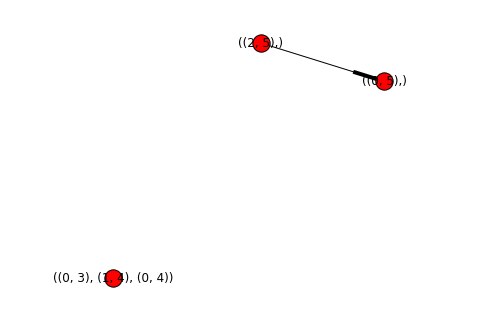

In [22]:
nx.draw(edge_dag, 
        pos=graphviz_layout(edge_dag),
        with_labels=True,
        prog='dot')


In [70]:
grqc_g = load_graph('data/grqc/graph.gt') 
cand_edges = pkl.load(open('data/grqc/recommended_edges_N10.pkl', 'rb'))

In [73]:
edge_dag = get_edge_dag(grqc_g, cand_edges, verbose=False)

100%|██████████| 38067/38067 [02:07<00:00, 299.34it/s]


In [74]:
print('num. cand edges / num. edge nodes = {} / {}'.format(len(cand_edges), edge_dag.number_of_nodes()))

num. cand edges / num. edge nodes = 38067 / 23360


In [92]:
node_sizes = pd.Series([len(n) for n in edge_dag.nodes()])
local_weighted_gains = pd.Series([edge_dag.node[n]['local_weighted_gain'] for n in edge_dag.nodes()])
inc_weighted_gains = pd.Series([edge_dag.node[n]['inc_weighted_gain'] for n in edge_dag.nodes()])

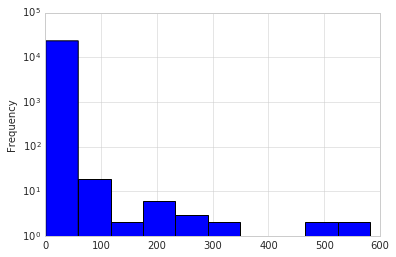

In [77]:
node_sizes.plot('hist', logy=True)

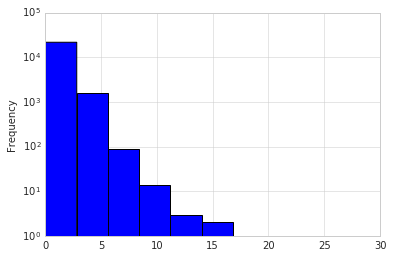

In [89]:
local_weighted_gains.plot('hist', logy=True)

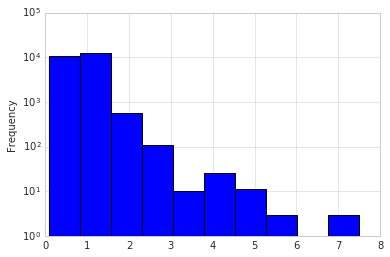

In [93]:
inc_weighted_gains.plot('hist', logy=True)

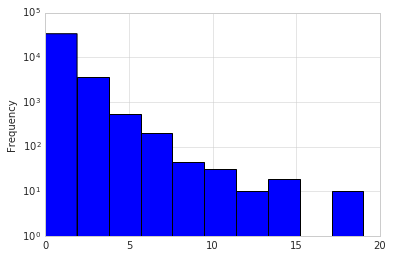

In [87]:
# edge weights on single nodes
glist = Glist(gt2nk(grqc_g))
single_edges_gain = pd.Series([len(glist.fake_insert(*e)) for e in cand_edges])
single_edges_gain.plot('hist', logy=True)

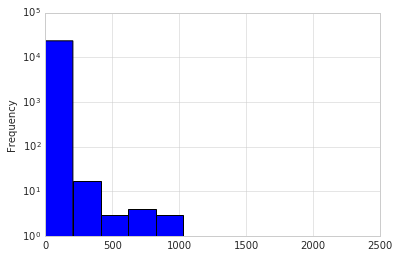

In [100]:
pd.Series().plot('hist', logy=True)

In [142]:
# simple heuristic:
# greedily select leaf nodes
verbose = False
add_edges = set()
selected_edges = []
B = 1000
for n in edge_dag.nodes_iter():
    edge_dag.node[n]['selected'] = False
    
while True:
    best_meta_node = None
    best_gain = 0
    for n in edge_dag.nodes_iter():
        if not edge_dag.node[n]['selected']:
            if edge_dag.node[n]['inc_weighted_gain'] > best_gain:
                best_meta_node = n
                best_gain = edge_dag.node[n]['inc_weighted_gain']
                
    if best_meta_node is None:
        break
    else:
        if verbose:
            print('best_meta_node', best_meta_node)
            print('gain', best_gain)
        new_edges = []
        def update_func(g, n):
            # needs to update inc_weighted_gain
            global new_edges
            if not g.node[n]['selected']:
                g.node[n]['selected'] = True
                new_edges += list(n)
        def stop_func(g, n):
            return g.node[n]['selected']
        
        recurse_down(edge_dag, best_meta_node, update_func, stop_func)
        if verbose:
            print('new_edges', new_edges)
        B -= len(new_edges)
        print(B)
        if B < 0:
            break
        selected_edges += new_edges

        

998
997
996
995
994
993
992
991
990
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
955
954
953
952
951
950
949
948
946
945
944
942
941
939
938
937
936
935
934
933
932
931
930
929
926
925
924
923
922
921
920
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
900
899
898
897
896
895
894
891
890
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
863
862
859
858
857
856
855
854
853
852
850
847
843
840
839
837
835
833
829
828
825
822
821
820
818
817
812
809
808
805
802
799
795
794
793
791
789
788
787
786
785
782
781
780
779
778
776
775
774
773
770
769
768
766
764
763
761
760
758
757
756
755
754
753
752
751
750
749
748
747
746
745
744
743
742
741
740
739
738
737
735
734
733
732
729
728
727
726
725
724
723
722
721
720
718
717
715
713
710
709
708
707
706
705
704
703
702
700
698
695
694
693
692
690
689
688
687
686
684
683
682
681
677
676
675
673
672
671
670
667
665
664
663


In [146]:
pkl.dump(selected_edges, open('output/grqc/edge_dag/B1000-N10.pkl', 'wb'))